# Retrieval-Augmented Generation with ChromaDB

## Learning Goals
- Understand the architecture of RAG (indexing → retrieval → generation).
- Implement a minimal RAG pipeline with LangChain and ChromaDB.
- Compare different chunking strategies and their effect on retrieval.
- Query the vector database and inject retrieved context into the LLM prompt.

In [11]:
# %load get_llm.py
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# Prefer the dedicated package; fallback keeps compatibility with older installs.
try:
    from langchain_ollama import ChatOllama
except ImportError:
    from langchain_community.chat_models import ChatOllama


load_dotenv()


def get_llm(provider: str = "openai"):
    provider = provider.strip().lower()

    if provider == "openai":
        if not os.getenv("OPENAI_API_KEY"):
            raise ValueError(
                "OPENAI_API_KEY not found. Add it to your .env before using provider='openai'."
            )
        return ChatOpenAI(model="gpt-4o-mini", temperature=0)

    if provider == "ollama":
        return ChatOllama(model="gemma2:2b", temperature=0)

    raise ValueError("Unsupported provider. Use 'openai' or 'ollama'.")


In [ ]:
import os
from dotenv import load_dotenv

from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage

load_dotenv()

# It is assumed that get_llm() is defined elsewhere (Notebook 2 helper)
llm = get_llm("openai")  # or get_llm("ollama")

## Step 1 — Load sample documents
A small text file is created and used for demonstration.

In [13]:
sample_text = """
Databases are organized collections of structured information or data,
typically stored electronically in a computer system.
Artificial intelligence (AI) refers to systems that can perform tasks that
normally require human intelligence, such as reasoning and learning.
LLM-based agents combine large language models with external tools.
"""

os.makedirs("data", exist_ok=True)
with open("data/sample_doc.txt", "w") as f:
    f.write(sample_text)

loader = TextLoader("data/sample_doc.txt")
docs = loader.load()

print("Loaded document:")
print(docs[0].page_content)

Loaded document:

Databases are organized collections of structured information or data,
typically stored electronically in a computer system.
Artificial intelligence (AI) refers to systems that can perform tasks that
normally require human intelligence, such as reasoning and learning.
LLM-based agents combine large language models with external tools.



## Step 2 — Chunking
The document is split into overlapping chunks to fit into the model context window.

In [14]:
splitter = RecursiveCharacterTextSplitter(chunk_size=180, chunk_overlap=20)
chunks = splitter.split_documents(docs)

print("Number of chunks:", len(chunks))
for i, c in enumerate(chunks):
    print(f"Chunk {i}: {c.page_content}")

Number of chunks: 3
Chunk 0: Databases are organized collections of structured information or data,
typically stored electronically in a computer system.
Chunk 1: Artificial intelligence (AI) refers to systems that can perform tasks that
normally require human intelligence, such as reasoning and learning.
Chunk 2: LLM-based agents combine large language models with external tools.


## Step 3 — Embedding + Indexing in ChromaDB
Each chunk is converted into embeddings and stored in a local ChromaDB instance.

In [16]:
# embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"}
)

vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model,
    persist_directory="data/chroma_store"
)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 359.34it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


ImportError: Could not import chromadb python package. Please install it with `pip install chromadb`.

## Step 4 — Retrieval
Semantic search is performed over the vectorstore.

In [ ]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 2})

query = "What is artificial intelligence?"
results = retriever.get_relevant_documents(query)

print("Retrieved chunks:")
for r in results:
    print("-", r.page_content)

Retrieved chunks:
- Artificial intelligence (AI) refers to systems that can perform tasks that
- Artificial intelligence (AI) refers to systems that can perform tasks that


/tmp/ipykernel_1886745/1810345979.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = retriever.get_relevant_documents(query)


## Step 5 — Generation with retrieved context
The retrieved chunks are injected into a prompt template before calling the LLM.

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Use the following context to answer:\n\n{context}"),
    ("human", "{question}")
])

def rag_pipeline(question: str):
    # Retrieve
    retrieved_docs = retriever.get_relevant_documents(question)
    context = "\n".join([doc.page_content for doc in retrieved_docs])

    # Generate
    chain = prompt_template | llm
    return chain.invoke({"context": context, "question": question}).content

print(rag_pipeline("What is a database?"))
print(rag_pipeline("What are LLM-based agents?"))

A database is an organized collection of structured information or data. It allows for efficient storage, retrieval, and management of data, often using a database management system (DBMS). Databases can store various types of information and are commonly used in applications ranging from business operations to personal data management.
LLM-based agents are systems that integrate large language models (LLMs) with external tools and resources to perform various tasks. These agents leverage the natural language processing capabilities of LLMs to understand and generate human-like text, while also utilizing external tools to enhance their functionality. This combination allows them to perform complex operations, such as retrieving information, executing commands, or interacting with other software applications, making them versatile in applications like customer support, content generation, and data analysis.


### Reflection
- RAG decouples **knowledge storage** (ChromaDB) from **reasoning** (LLM).
- Chunking is critical: too small → fragmented context; too large → exceeds token limits.
- The vector database enables **semantic search**, not keyword search.
- This architecture is the basis for practical applications like Q&A over documents.

## Exercises
1. Replace the sample document with a **PDF loader** (e.g., `PyPDFLoader`) and index a real article.
2. Change the chunk size and observe how retrieval quality changes.
3. Experiment with different embedding models (`all-MiniLM`, `multi-qa-mpnet-base-dot-v1`).
4. Persist the ChromaDB index and reload it in a new notebook.

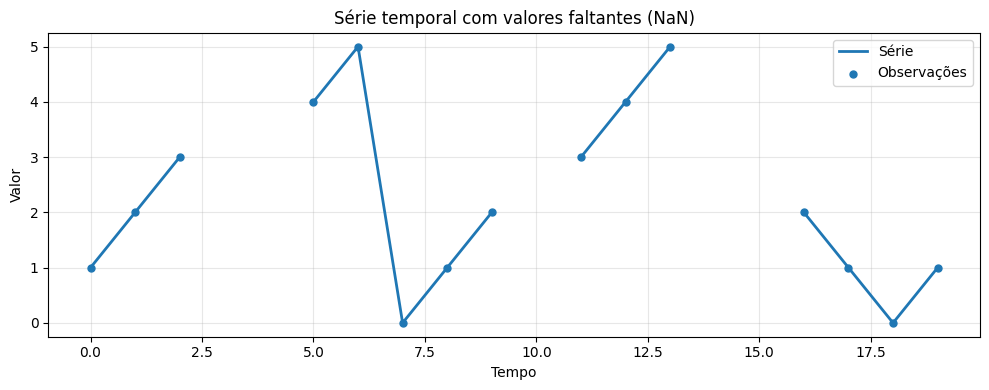

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Exemplo (substitua pelos seus dados)
t = np.arange(0, 20)
y = np.array([1, 2, 3, np.nan, np.nan, 4, 5, 0, 1, 2,
              np.nan, 3, 4, 5, np.nan, np.nan, 2, 1, 0, 1])

plt.figure(figsize=(10, 4))

# Linha (vai quebrar onde tiver NaN)
plt.plot(t, y, linewidth=2, label="Série")

# Pontos observados (só onde não é NaN)
mask = ~np.isnan(y)
plt.scatter(t[mask], y[mask], s=25, zorder=3, label="Observações")

plt.title("Série temporal com valores faltantes (NaN)")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
